<a href="https://colab.research.google.com/github/Samsodar/Coursera_Capstone/blob/main/Capstone%20Project%20Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stockholm

#**Data preparation**

##**Getting the source data**

In [39]:
# Let's start by imptoring all the libraries to be used in this assignment.
import numpy as np 
import pandas as pd 
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import lxml
print('Libraries imported.')

Libraries imported.


In [53]:
#let's get the list of Stockholm municipalities
response = requests.get('https://en.wikipedia.org/wiki/Stockholm_County').text
soup = BeautifulSoup(response, 'lxml')

In [54]:
stockholm_table = soup.find('table', {'class':'sortable wikitable'})
df_sthlmkommuner = pd.read_html(str(stockholm_table))[0]
headers = ['Sthlm Municipality','Population','Area size, km']
df_sthlmkommuner.columns = headers
df_sthlmkommuner.head()

,Sthlm Municipality,Population,"Area size, km"
0,Botkyrka,93106,194
1,Danderyd,33187,26
2,Ekerö,28308,217
3,Haninge,89989,458
4,Huddinge,111722,131


In [55]:
df_sthlmkommuner['Density'] = (df_sthlmkommuner['Population']/df_sthlmkommuner['Area size, km'])
df_sthlmkommuner.head(26)

,Sthlm Municipality,Population,"Area size, km",Density
0,Botkyrka,93106,194,479.927835
1,Danderyd,33187,26,1276.423077
2,Ekerö,28308,217,130.451613
3,Haninge,89989,458,196.482533
4,Huddinge,111722,131,852.839695
5,Järfälla,78480,54,1453.333333
6,Lidingö,47818,31,1542.516129
7,Nacka,103656,95,1091.115789
8,Norrtälje,61769,2015,30.654591
9,Nykvarn,10923,153,71.392157


In [56]:
df_sthlmkommuner.at[11,'Sthlm Municipality']='Salem kommun'
df_sthlmkommuner.head(26)

,Sthlm Municipality,Population,"Area size, km",Density
0,Botkyrka,93106,194,479.927835
1,Danderyd,33187,26,1276.423077
2,Ekerö,28308,217,130.451613
3,Haninge,89989,458,196.482533
4,Huddinge,111722,131,852.839695
5,Järfälla,78480,54,1453.333333
6,Lidingö,47818,31,1542.516129
7,Nacka,103656,95,1091.115789
8,Norrtälje,61769,2015,30.654591
9,Nykvarn,10923,153,71.392157


In [57]:
from geopy.geocoders import Nominatim

In [58]:
# Enrich the dataset with longtitude and latitide coordinates
geolocator = Nominatim(user_agent="foursquare_agent")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df_sthlmkommuner['location'] = df_sthlmkommuner['Sthlm Municipality'].apply(geocode)
df_sthlmkommuner['lat'] = df_sthlmkommuner['location'].apply(lambda loc: loc.point[0] if loc else None)
df_sthlmkommuner['lon'] = df_sthlmkommuner['location'].apply(lambda loc: loc.point[1] if loc else None)

#4. Let's see the result
df_sthlmkommuner.head()

,Sthlm Municipality,Population,"Area size, km",Density,location,lat,lon
0,Botkyrka,93106,194,479.927835,"(Botkyrka kommun, Stockholms län, Sverige, (59...",59.203449,17.854598
1,Danderyd,33187,26,1276.423077,"(Danderyds kommun, Stockholms län, Sverige, (5...",59.400000,18.050000
2,Ekerö,28308,217,130.451613,"(Ekerö kommun, Stockholms län, Sverige, (59.33...",59.333333,17.600000
3,Haninge,89989,458,196.482533,"(Haninge kommun, Stockholms län, Sverige, (59....",59.049722,18.266667
4,Huddinge,111722,131,852.839695,"(Huddinge, Huddinge kommun, Stockholms län, 14...",59.229383,17.974881


#Methodology

In [60]:
#Next, I am going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
#Defining Foursquare Credentials and Version
CLIENT_ID = 'MJDJFF40RK5BY3VGN55SV5VH11Z5RGRYV2C10L0TTAZOQEGA' # my Foursquare ID
CLIENT_SECRET = 'WUPL5WPY33VQVUGMYPIJKGRKQWTIIOPS1TQVJW4TMVUYV3EG' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MJDJFF40RK5BY3VGN55SV5VH11Z5RGRYV2C10L0TTAZOQEGA
CLIENT_SECRET:WUPL5WPY33VQVUGMYPIJKGRKQWTIIOPS1TQVJW4TMVUYV3EG


In [61]:
import folium

In [62]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [80]:
#we will store it in new dataframe that is the copy of our source data + we will add calculated fields
df_gymkommuner = df_sthlmkommuner[:]
catId = '4bf58dd8d48988d175941735' #convinience store API id

searchRadius = 15000

for i in range(len(df_gymkommuner)):
    df_gymkommuner.loc[i,'Amount_Gyms'] = int(get_venues_count(str(df_gymkommuner.loc[i,'lat'])+', ' + str(df_gymkommuner.loc[i,'lon']), radius = searchRadius, categoryId=catId))

#number of convinience stores per 1000 habitants    
for i in range(len(df_gymkommuner)):
    df_gymkommuner.loc[i,'Density_Gyms'] = df_gymkommuner.loc[i,'Amount_Gyms']/df_gymkommuner.loc[i,'Density']*1000
    
df_gymkommuner.head(26)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Sthlm Municipality,Population,"Area size, km",Density,location,lat,lon,Amount_Gyms,Density_Gyms
0,Botkyrka,93106,194,479.927835,"(Botkyrka kommun, Stockholms län, Sverige, (59...",59.203449,17.854598,62.0,129.186089
1,Danderyd,33187,26,1276.423077,"(Danderyds kommun, Stockholms län, Sverige, (5...",59.400000,18.050000,122.0,95.579594
2,Ekerö,28308,217,130.451613,"(Ekerö kommun, Stockholms län, Sverige, (59.33...",59.333333,17.600000,12.0,91.988131
3,Haninge,89989,458,196.482533,"(Haninge kommun, Stockholms län, Sverige, (59....",59.049722,18.266667,9.0,45.805598
4,Huddinge,111722,131,852.839695,"(Huddinge, Huddinge kommun, Stockholms län, 14...",59.229383,17.974881,120.0,140.706396
5,Järfälla,78480,54,1453.333333,"(Järfälla kommun, Stockholms län, Sverige, (59...",59.416667,17.766667,94.0,64.678899
6,Lidingö,47818,31,1542.516129,"(Lidingö, Lidingö kommun, Stockholms län, 181 ...",59.364384,18.133142,126.0,81.684721
7,Nacka,103656,95,1091.115789,"(Nacka kommun, Stockholms län, Sverige, (59.31...",59.312100,18.207359,120.0,109.979162
8,Norrtälje,61769,2015,30.654591,"(Norrtälje kommun, Stockholms län, Sverige, (5...",59.766667,18.700000,4.0,130.486166
9,Nykvarn,10923,153,71.392157,"(Nykvarns kommun, Stockholms län, Sverige, (59...",59.200000,17.416667,11.0,154.078550


In [81]:
df_gymkommuner.to_csv('df_gymkommuner.csv', index=False)

In [82]:
df_gymkommuner = pd.read_csv('df_gymkommuner.csv')
df_gymkommuner.head()

,Sthlm Municipality,Population,"Area size, km",Density,location,lat,lon,Amount_Gyms,Density_Gyms
0,Botkyrka,93106,194,479.927835,"Botkyrka kommun, Stockholms län, Sverige",59.203449,17.854598,62.0,129.186089
1,Danderyd,33187,26,1276.423077,"Danderyds kommun, Stockholms län, Sverige",59.400000,18.050000,122.0,95.579594
2,Ekerö,28308,217,130.451613,"Ekerö kommun, Stockholms län, Sverige",59.333333,17.600000,12.0,91.988131
3,Haninge,89989,458,196.482533,"Haninge kommun, Stockholms län, Sverige",59.049722,18.266667,9.0,45.805598
4,Huddinge,111722,131,852.839695,"Huddinge, Huddinge kommun, Stockholms län, 141...",59.229383,17.974881,120.0,140.706396


#Analysis

In [83]:
df_gymkommuner.describe()

,Population,"Area size, km",Density,lat,lon,Amount_Gyms,Density_Gyms
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,90158.615385,250.923077,1053.025117,59.353412,18.019946,62.961538,106.535586
std,180163.404706,391.099673,1549.724839,0.181759,0.306881,50.336055,74.039726
min,10923.000000,9.000000,30.654591,58.905646,17.416667,4.000000,22.605015
25%,33248.250000,55.000000,133.760985,59.219846,17.788650,12.750000,66.168025
50%,48067.000000,142.000000,395.389843,59.362124,17.988125,60.000000,94.780567
75%,80332.500000,324.000000,1249.927963,59.457329,18.214340,117.750000,128.590377
max,962154.000000,2015.000000,5618.222222,59.766667,18.700000,132.000000,414.871496


#Clustering


In [88]:
from sklearn.cluster import KMeans

In [114]:
df_sthlmfinal=df_gymkommuner.drop(columns=['Sthlm Municipality', 'Population', 'Area size, km', 'Density', 'location', 'Amount_Gyms'])
df_sthlmfinal.head()

,lat,lon,Density_Gyms
0,59.203449,17.854598,129.186089
1,59.400000,18.050000,95.579594
2,59.333333,17.600000,91.988131
3,59.049722,18.266667,45.805598
4,59.229383,17.974881,140.706396


In [115]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_sthlmfinal)
    distortions.append(kmeanModel.inertia_)

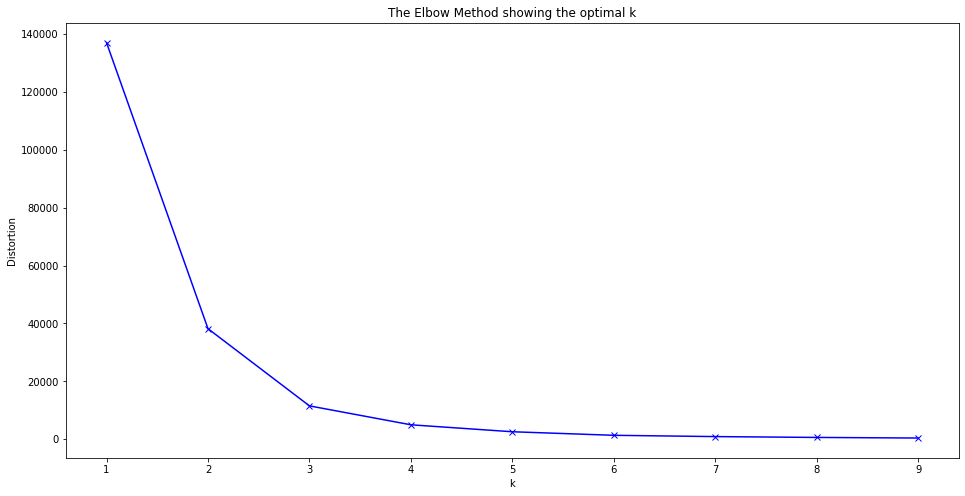

In [116]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [117]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_sthlmfinal)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:9]

array([2, 0, 0, 0, 2, 0, 0, 2, 2], dtype=int32)

In [118]:
df_sthlmfinal.insert(0, 'Cluster Labels', kmeans.labels_)

In [105]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library

In [119]:
# create map
latitude = 59.3293235
longitude = 18.0685808
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9, height =600, width = 600)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_sthlmfinal['lat'], df_sthlmfinal['lon'], df_sthlmfinal['Density_Gyms'], df_sthlmfinal['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters